### Using *approxposterior* with user-defined functions

---

David P. Fleming, 2018

Using *approxposterior* as it was meant to be used!  In this notebook, I show how a user defines functions, like the loglikelihood function, to use *approxposterior* with their own forward model.  To do so, I reproduce Dan Forman-Mackey's *emcee* "fitting a line" example posted here: https://emcee.readthedocs.io/en/latest/tutorials/line/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner

from approxposterior import bp

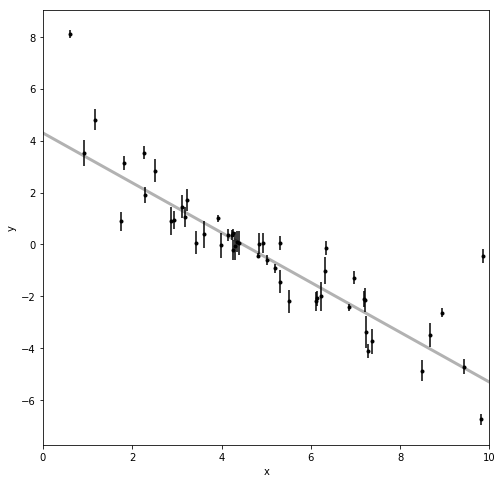

In [2]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("y");

In [3]:
# Define a loglikelihood function
# This is the "forward model" (in this case, a line)
def log_likelihood(theta, x, y, yerr):
  
    theta = np.array(theta)
    m, b, log_f = theta
    
    model = m * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


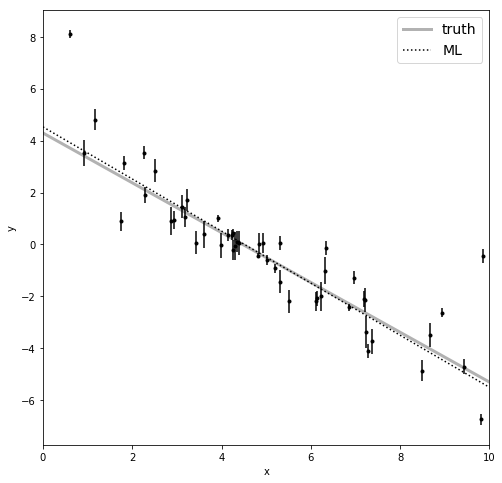

In [4]:
# Find maximum likelihood solution by minimizing negative loglikelihood
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

# Print the fit
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

# Plot it!
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
ax.legend(fontsize=14)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("y");

In [5]:
def log_prior(theta):
    
    theta = np.array(theta)
    m, b, log_f = theta
    
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [6]:
def log_probability(theta, x, y, yerr):
        
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [7]:
p0 = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = p0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(p0, 5000);

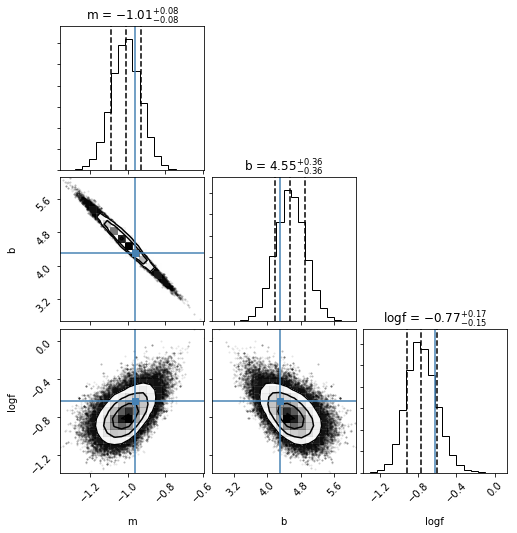

In [8]:
fig = corner.corner(sampler.flatchain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[m_true, b_true, np.log(f_true)],
                    labels=["m", "b", "logf"],
                    plot_contours=True, show_titles=True);

In [9]:
def sample_function(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 3 array of floats samples from the prior
    """

    m = np.random.uniform(low=-5, high=0.5, size=(n))
    b = np.random.uniform(low=0, high=10, size=(n))
    log_f = np.random.uniform(low=-10, high=1, size=(n))
    
    return np.vstack([m,b,log_f]).squeeze().T
# end function

In [10]:
m0 = 50                        # Initial size of training set
m = 20                            # Number of new points to find each iteration
nmax = 5                       # Maximum number of iterations
M = int(5.0e3)                    # Number of MCMC steps to estimate approximate posterior
Dmax = 0.01                       # KL-Divergence convergence limit
kmax = 5                          # Number of iterations for Dmax convergence to kick in
which_kernel = "ExpSquaredKernel" # Which Gaussian Process kernel to use
bounds = ((-5,0.5), (0.0,10.0), (-10.0,1.0))         # Prior bounds
algorithm = "bape"                 # Use the Kandasamy et al. (2015) formalism

In [11]:
ap = bp.ApproxPosterior(lnprior=log_prior,
                        lnlike=log_likelihood,
                        prior_sample=sample_function,
                        algorithm=algorithm)

In [12]:
# Run!
ap.run(m0=m0, m=m, M=M, nmax=nmax, Dmax=Dmax, kmax=kmax,
       bounds=bounds, which_kernel=which_kernel,
       n_kl_samples=100000, verbose=False,
       timing=True, args=(x, y, yerr))

[-43465665034.32945, -43465665034.329445, -23758022712.004726, -23758022712.00472, -43465665034.32946, -43465665034.32945, -43465665034.32946, -43465665034.32945, -43465665034.329445, -43465665034.32945]
[-45574789432.50763, -45574789432.50762, -23760124435.55369, -23760124435.553688, -45574789432.50762, -45574789432.50762, -45574789432.507614, -23760124435.553707, -45574789432.50762, -45574789432.50764]
[-48027825580.19079, -48027825580.19079, -48027825580.19078, -24087319408.99965, -48027825580.19079, -48027825580.19078, -24087319408.999638, -24087319408.999634, -48027825580.19078, -48027825580.19079]
[-24103902080.94244, -48493950171.3635, -48493950171.3635, -24103902080.942425, -24103902080.94244, -48493950171.3635, -48493950171.3635, -48493950171.3635, -48493950171.36351, -48493950171.3635]
[-24106667209.62477, -48622318010.91645, -48622318010.91644, -48622318010.91644, -48622318010.91644, -48622318010.91645, -48622318010.91645, -48622318010.91644, -48622318010.91644, -48622318010

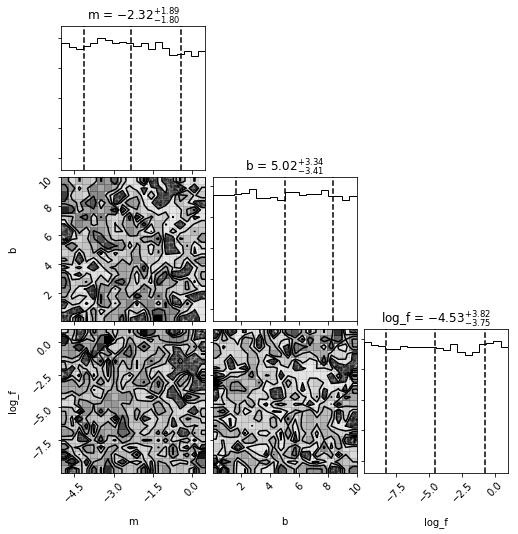

In [13]:
ind = -1
fig = corner.corner(ap.samplers[ind].flatchain[ap.iburns[ind]:],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, scale_hist=True,
                    plot_contours=True,
                    labels=["m", "b", "log_f"]);

In [14]:
np.mean(np.array(ap.theta)**2, axis=0)*2

array([13.53685359, 62.86957144, 62.23205705])

In [15]:
ap.gp.get_parameter_vector()

array([-21993.78037137,   -161.1184384 ,    213.18911188,     39.47745881])

In [16]:
np.exp(ap.gp.get_parameter_vector())

array([0.00000000e+00, 1.06451373e-70, 3.86237905e+92, 1.39586212e+17])